# Analyzing NYC High School Data
---
This is a guided project part of the Dataquest.io courses. The goal of this project is to examine NYC high school data to find out what causes high SAT scores.

There is a good amount of public data available regarding education statistics and SAT scores. The only issue is that these are available in separate sources. Therefore the first part of this project we will need to read in the data and clean it up enough so that all of the datasets can be combined.

The analysis can begin once the datasets have been combined.

# Read in the data

In [112]:
import pandas as pd
import numpy as np
import re
import matplotlib

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("data/schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [113]:
all_survey = pd.read_csv("data/schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("data/schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0, sort=False)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

The DBN column is the key field that will be used to join the various datasets together.

In [114]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [115]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [116]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [117]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [118]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [110]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [86]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [87]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

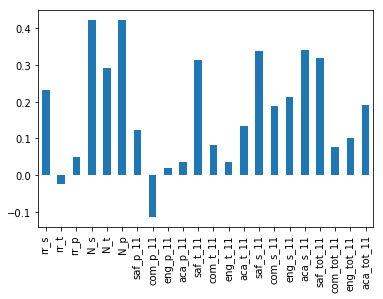

In [88]:
%matplotlib inline
combined.corr()["sat_score"][survey_fields].plot.bar()

This a bar graph that compares SAT scores with responders on various school surveys. For example, the comp_p_11 column means the communication score from parents who answered the survey. In this case, where the communication score was reated poorly, this indicates a very loose negative correlation with SAT score.

The highest two values are the N_s and the N_p columns, which are the number of student and parent respondents respectively. It should be expected that these would be high given that these fields are related to student enrollment. The next highest are the aca_s_11, saf_s_11, saf_t_11, and saf_tot_11 columns, the _saf_ columns means Safety and Respect. _Aca_ means academic expectations.

There appears to be a definitive positive correlation between the scores and this Safety/Respect category. For academic expectations, the response is higher for students rather than teachers.

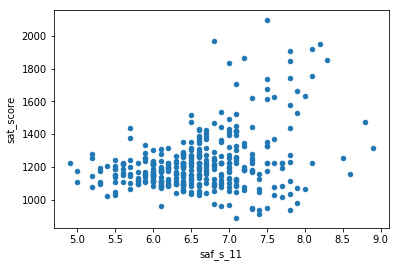

In [89]:
%matplotlib inline
combined.plot.scatter(x="saf_s_11", y="sat_score")

There appears to be a positive correlation between safety score and SAT score, although it appears to be weak. We can generally see that generally a low safety score will result in a low SAT score. A high safety score however, has a weaker correlation and less likely to result in a high SAT score.

## Visualising Safety Scores Geographically

Now we'll try mapping the safety score against projects of the NYC boroughs. To do this we'll use GeoPandas, a library that offers most of the same functionality as Pandas, but also includes support for certain geographical dimensions that allow for spatial mapping.

Coincidentally, Geopandas includes sample data that contain shapefiles for the five boroughs of New York, these files will be used to draw the borders of the five boroughs.

Two of the data types that Geopandas introduces are a _Point_ and _Polygon_. A point represents a coordinate pair in the format of longitude and latitude. The coordinates in the existing data frame, although it has latitidue and longitude pairs that we need is not in the correct format required by Geopanads. To convert, we'll use the Shaprely library to convert this into a _Point_.

One of the trickiest things about working with these geo data types is managing the CRS, or _Coordinate Reference System_. When mapping spatial data, the CRS much match between all data sets otherwise the points and shape may not line up correctly.

Finding and converting the CRS is relatively simple. GeoSeries and GeoDataFrames have a CRS property. Converting is also similarily straightforward. Use the `to_crs()` method, and pass in a dictionary in the format of `{'init': 'epsg:2263'}` to convert.

Note that if we check the CRS of the GeoDataFrame for our safety scores GeoDataFrame, there is none. Before matching the CRS the NYC boundaries, a CRS must be set first. For reasons to be researched later, the correct CRS to pass in is 4326. CRS codes can be researched using this site: https://www.epsg-registry.org

In [90]:
safs_by_dist = combined.groupby('school_dist')[['lat','lon','saf_s_11']].mean()


None


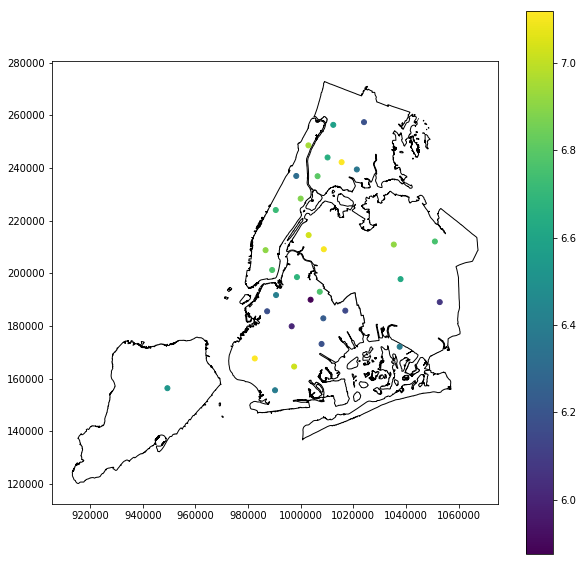

In [217]:
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx

# use the built-in data from Geopandas to draw the borough boundaries
nybb = gpd.read_file(gpd.datasets.get_path('nybb'))

# convert the above data into a GeoDataFrame
geometry = [Point(xy) for xy in zip(safs_by_dist['lon'], safs_by_dist['lat'])]

geo_safs_by_dist = gpd.GeoDataFrame(safs_by_dist, geometry=geometry)
geo_safs_by_dist = geo_safs_by_dist.drop(['lat', 'lon'], axis=1)
#nybb = nybb.to_crs(epsg=8807)
print(geo_safs_by_dist.crs)
geo_safs_by_dist.crs = {'init': 'epsg:4326'}
geo_safs_by_dist = geo_safs_by_dist.to_crs({'init': 'epsg:2263'})

base = nybb.plot(figsize=(10,10), color='white', edgecolor='black')
geo_safs_by_dist.plot(ax=base, column='saf_s_11', marker='o', markersize=25, cmap='viridis', legend=True)

Each dot on this map represents a school district in New York. This is cool.

Various other shapefiles are available from the city as well, including one for school district boundaries. Using this shapefile, we can create a choropleth map showing each district and color it according to its safety score.

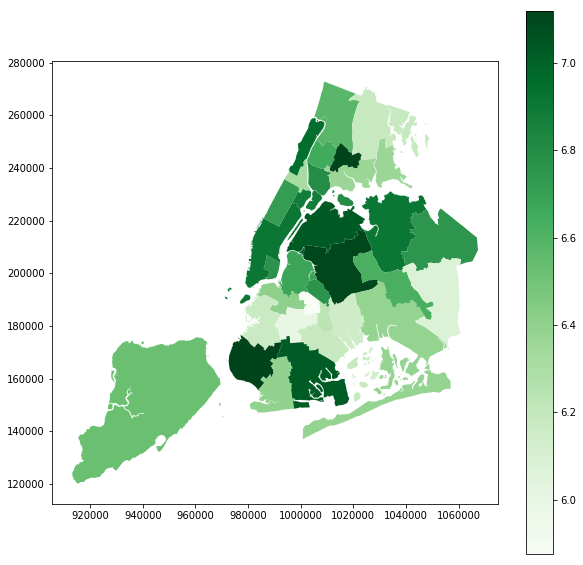

In [224]:
nysd_safs.plot(figsize=(10,10), column='saf_s_11', cmap='Greens', legend=True)

By using GeoPandas we can create a choropleth math after some fairly simple data formatting. The darker green colors indicate a higher safety score, while lighter ones indicate a lower score. There doesn't seem to be any obvious patterns between safety score and geographic location. Each borough, aside from Staten Island, seems to have a reasonably wide dispersion of safety scores across the map.

## Visualising Relation Between Ethnicity and Score

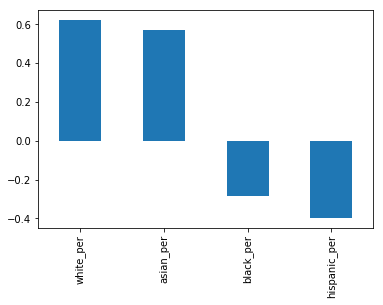

In [234]:
ethnicities = ['white_per','asian_per','black_per','hispanic_per']
combined.corr()['sat_score'][ethnicities].plot.bar()

A quick bar plot shows us that whites and Asians tend to have higher SAT scores, while blacks and Hispanics have a negative correlation with SAT score, although for the latter two, the correlation coefficient is not as high.

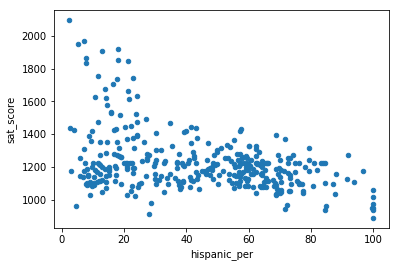

In [235]:
combined.plot.scatter(x='hispanic_per', y='sat_score')

Plotting Hispanics againist SAT score shows us a negative, non-linear relationship between Hispanics in a school versus SAT Score.

In [261]:
combined.columns[151:200]

Index(['priority06', 'priority07', 'priority08', 'priority09', 'priority10',
       'Location 1', 'lat', 'lon'],
      dtype='object')

In [257]:
cols_of_interest = ['school_name', 'boro', 'school_type', 'total_students','hispanic_per', 'sat_score']
combined[combined['hispanic_per'] > 95][cols_of_interest]


,school_name,boro,school_type,extracurricular_activities,total_students,hispanic_per,sat_score
44,Manhattan Bridges High School,Manhattan,0,"Academic Intervention Services (Extended Day),...",552.0,99.8,1058.0
82,Washington Heights Expeditionary Learning School,Manhattan,0,"Academic Tutoring, Aerobics, Band, Baseball, B...",650.0,96.7,1174.0
89,Gregorio Luperon High School for Science and M...,Manhattan,0,"Chorus, Dance, Drama, Hiking, History Through ...",491.0,99.8,1014.0
125,Academy for Language and Technology,Bronx,0,"Adobe Photoshop, ALT Community Service Committ...",301.0,99.4,951.0
141,International School for Liberal Arts,Bronx,0,"Chess, Council for Unity, Newsletter, Poetry.",543.0,99.8,934.0
176,Pan American International High School at Monroe,Bronx,International School,"Homework Help, One-to-One Tutoring, Student Go...",401.0,99.8,970.0
253,Multicultural High School,Brooklyn,0,"Art, Chess, College Planning and Access, Engli...",322.0,99.8,887.0
286,Pan American International High School,Queens,International School,"Leadership Project, Peer Tutoring, Advanced En...",367.0,100.0,951.0


There are only eight schools with a 95% Hispanic students. Of note with these schools is that they are all relatively small schools. About half of these schools are specialised schools. Potentially for ESL students as suggested by some of the names.

In [263]:
cols_of_interest = ['school_name', 'boro', 'school_type', 'total_students', 'hispanic_per', 'sat_score']
combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)][cols_of_interest]

,school_name,boro,school_type,total_students,hispanic_per,sat_score
37,Stuyvesant High School,Manhattan,Specialized School,3292.0,2.4,2096.0
151,Bronx High School of Science,Bronx,Specialized School,3037.0,7.2,1969.0
187,Brooklyn Technical High School,Brooklyn,Specialized School,5458.0,7.9,1833.0
327,Queens High School for the Sciences at York Co...,Queens,Specialized School,419.0,7.9,1868.0
356,Staten Island Technical High School,Staten Island,Specialized School,1235.0,5.3,1953.0


On the opposite end, looking at the top schools by score listed, these are all specialised schools as defined by the `school_type` field. Coincidentally, there are five schools that match the criteria and each borough is represented by one school in the list.

## Visualising Correlations Between Gender and SAT Score

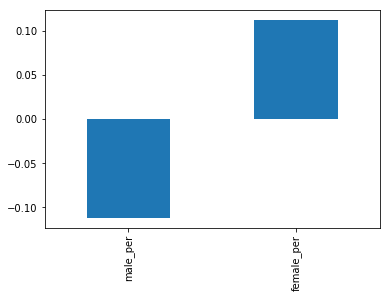

In [264]:
combined.corr()['sat_score'][['male_per', 'female_per']].plot.bar()

Plotting the correlation between genders and scores, we see that females have a higher correlation. However, as indicated by the correlation coefficients, both are weakly correlated.

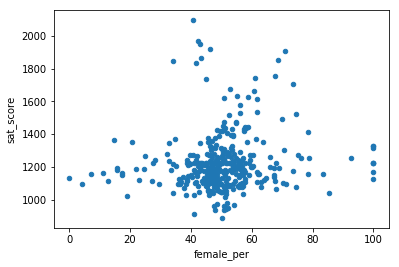

In [265]:
combined.plot.scatter(x='female_per', y='sat_score')

A scatter plot between these two columns shows us that there isn't much of a correlation between score and the percent of girls in schools. We can see that most schools generally have a even gender ratio. One interesting observation we can see is that the highest scores look like they come from schools with balanced gender ratios.

In [267]:
combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)][cols_of_interest]

,school_name,boro,school_type,total_students,hispanic_per,sat_score
5,Bard High School Early College,Manhattan,0,560.0,18.2,1856.0
26,Eleanor Roosevelt High School,Manhattan,0,531.0,11.6,1758.0
60,Beacon High School,Manhattan,Consortium School,1276.0,22.8,1744.0
61,Fiorello H. LaGuardia High School of Music & A...,Manhattan,Specialized School,2730.0,16.6,1707.0
302,Townsend Harris High School,Queens,0,1151.0,12.9,1910.0


A closer examination of the majority female schools with high SAT scores reveals that the schools listed here appear to be regarded highly in academics. These schools are highly selective and many of their students continue to high school.

## AP Exams Impact on SAT Scores
The next item examined is how AP Exams may affect SAT scores. We are expecting that schools with more AP test takers will have higher average scores. Since the total enrollment of scores tends has a strong correlation with the average SAT score for a school, we will examine the percent of AP test takers in a school instead, similar to how we examined the ratios of students in prior sections.

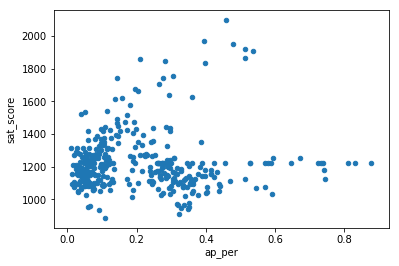

In [268]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']
combined.plot.scatter(x='ap_per', y='sat_score')

Examining the scatter plot of the percent of students that take AP exams versus SAT Score, we do see some evidence that it positively affects SAT scores. However, we can also see that the schools with the highest percentages do not show a higher score. 

In [270]:
combined['subway'].unique()

array(['B, D to Grand St ; F to East Broadway ; J, M, Z to Delancey St-Essex St',
       'F to East Broadway ; J, M, Z to Delancey St-Essex St',
       '6 to Astor Place ; L to 1st Ave',
       'B, D to Grand St ; F, J, M, Z to Delancey St-Essex St',
       'F, J, M, Z to Delancey St-Essex St', 0,
       '4, 5, Q to 14th St-Union Square ; 6, N, R to 23rd St ; L to 3rd Ave',
       'C, E to 50th St',
       '6, N, Q, R to Canal St ; B, D to Grand St ; F to East Broadway ; J, Z to Bowery ; M to Delancey St-Essex St',
       '1, R to Rector St ; 1, R to Whitehall St-South Ferry ; 2, 3 to Wall St ; 4, 5 to Bowling Green ; A, C to Fulton St-Broadway-Nassau ; E to World Trade Center ; J, Z to Broad St',
       '1, 2, 3, F, M to 14th St - 6th Ave ; 4, 5, 6, L, N, Q, R to 14th St-Union Square ; L to 3rd Ave',
       '1, 6, A, J, N, Q, R, Z to Canal St ; B, D, F, M to Broadway-Lafayette St ; C, E to Spring St ; N, R to Prince St',
       '1 to 18th St ; 2, 3, F, M to 14th St ; A, C, E, L to 14t